In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import math
import numpy as np
import matplotlib.pyplot as plt

%env OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag_env/opt/oommf/oommf.tcl

env: OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag_env/opt/oommf/oommf.tcl


In [3]:
mu0   = 4.0 * np.pi * 10**-7  # vacuum permeability             N/A^2
Ms    = 1.76/mu0                # saturation magnetisation        A/m
A     = 10e-12              # exchange coupling strength      J/m
Km    = mu0 * Ms**2     # magnetostatic energy density    kg/ms^2
lexch = (A/Km)**0.5   
Rcoey = (24)**0.5*lexch #needle
print(Ms)
print(lexch)
print(Rcoey)

1400563.499208679
2.014152103301723e-09
9.867289834885467e-09


1.0070760516508614e-09
200000.0
1.6113216826413782e-08


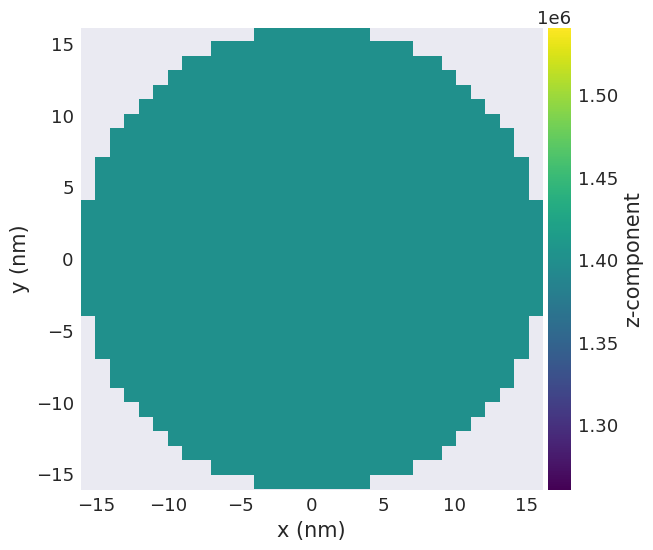

In [5]:
K1    = 20e4
u = (0, 0, 1)
N = 16
r = 8*lexch  # cube edge length (m) I had vortex at 9.7*lexch and z=-5r tpo 5r
cellsize = r/N  # discretisation in all three dimensions.
p1 = (-r, -r, -r)  # Minimum sample coordinate.
p2 = (r, r,r)  # Maximum sample coordinate.
cell = (cellsize, cellsize, cellsize)  # Discretisation.
mesh = df.Mesh(p1=p1, p2=p2, cell=(cellsize, cellsize, cellsize))  # Create a mesh object.

system = mm.System(name='Co3')

system.energy = mm.Exchange(A=A) + mm.UniaxialAnisotropy(K=K1, u=u) + mm.Demag()+mm.Zeeman(H=(0, 0, 0))

flower_init = (0, 0, 1)
def vortex_init(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    rho = x**2 + y**2
    phi = math.atan(x/y)
    b = 2*lexch
    m_phi = np.sin(2 * np.arctan(rho/b))
    return np.array([-m_phi*np.sin(phi), m_phi*np.cos(phi) , np.sqrt(1.0 - m_phi**2)])

def Ms_value(pos):
    x, y, z =  pos
    if x**2 + y**2  +z**2 < r**2:
        return Ms
    else:
        return 0
    
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms_value)
    
print(cellsize)
print(K1)
print(r)
system.m.plane('z').mpl()

In [ ]:
md = oc.MinDriver()
md.drive(system, overwrite=True)

evolve = oc.CGEvolver()
md = oc.MinDriver(stopping_mxHxm=0.01)


B1_array = np.arange(-2, +2, 0.06)
B2_array = np.arange(0.2, -0.1, -0.0001)
B_array =  np.append([B1_array], [B2_array])

mz = []
mx = []
my = []
S = []
S1 = []
S2 = []

for B in B2_array:
    # Marijan: This way we update the field.
    system.energy.zeeman.H = (0, 0, B/mm.consts.mu0)
    md.drive(system)
    # Marijan: A bit more cool way to extract the x-average normalised magnetisation :)
    mz.append(system.m.orientation.z.average)
    mx.append(system.m.orientation.x.average)
    my.append(system.m.orientation.y.average)
    m = system.m.orientation.plane(z=0.5*r)
    m1 = system.m.orientation.plane(x=0.5*r)
    m2 = system.m.orientation.plane(y=0.5*r)
    S.append(df.integral(m @ (m.derivative('x') & m.derivative('y')) * df.dx*df.dy) / 4 / 3.14)
    S1.append(df.integral(m1 @ (m1.derivative('y') & m1.derivative('z')) * df.dx*df.dy) / 4 / 3.14)
    S2.append(df.integral(m2 @ (m2.derivative('z') & m2.derivative('x')) * df.dx*df.dy) / 4 / 3.14)

Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (1.1 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (0.8 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/12 03:07]... 

Text(0, 0.5, 'Q')

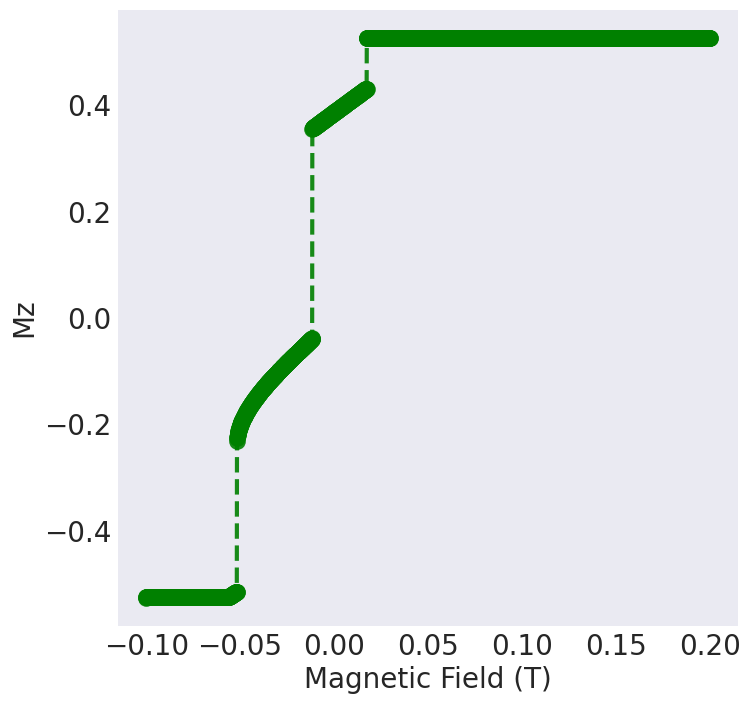

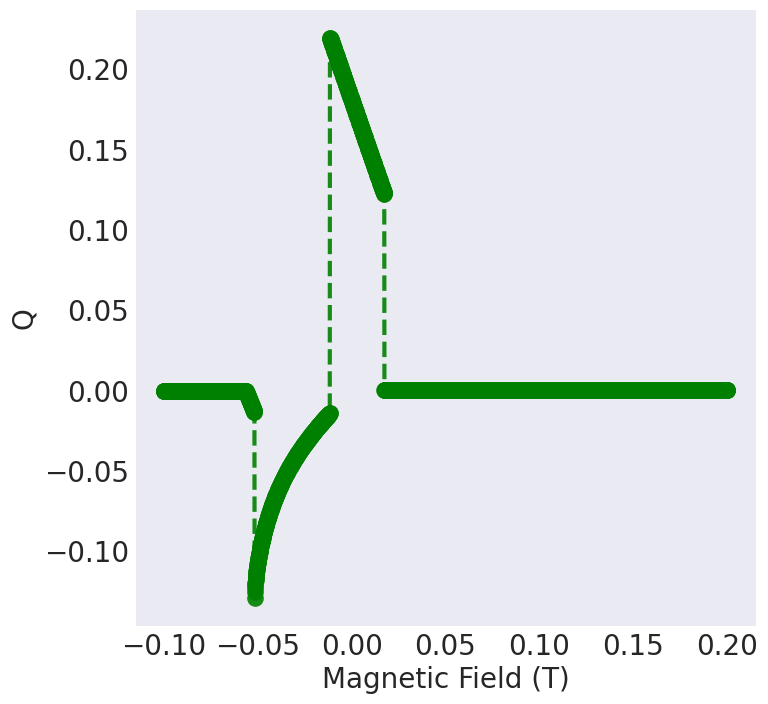

In [7]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,mz, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

Text(0, 0.5, 'Q')

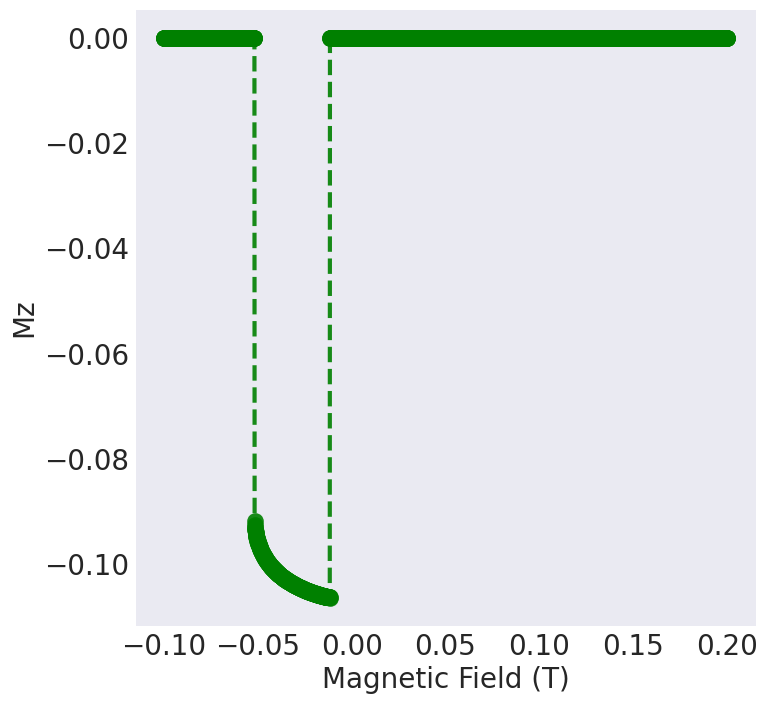

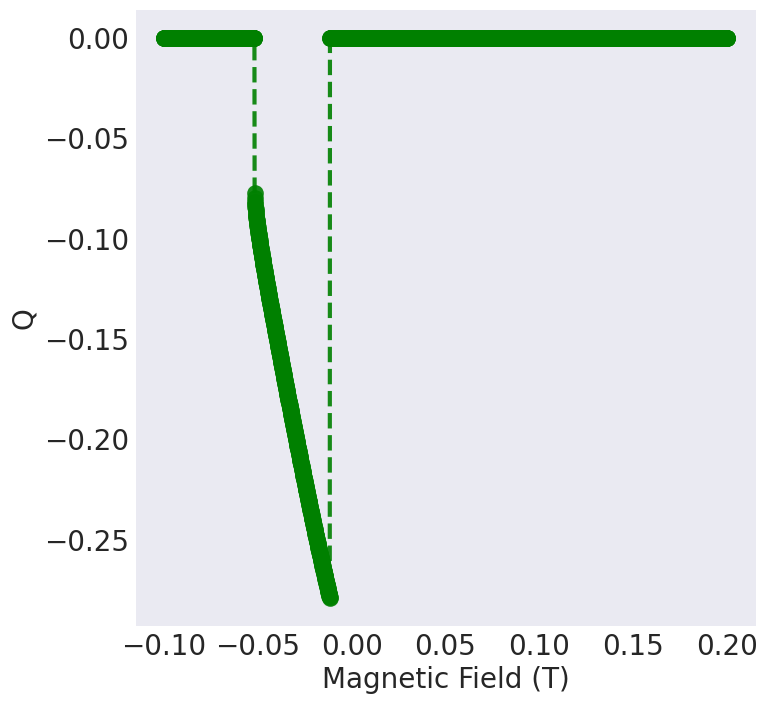

In [8]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,mx, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S1, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

Text(0, 0.5, 'Q')

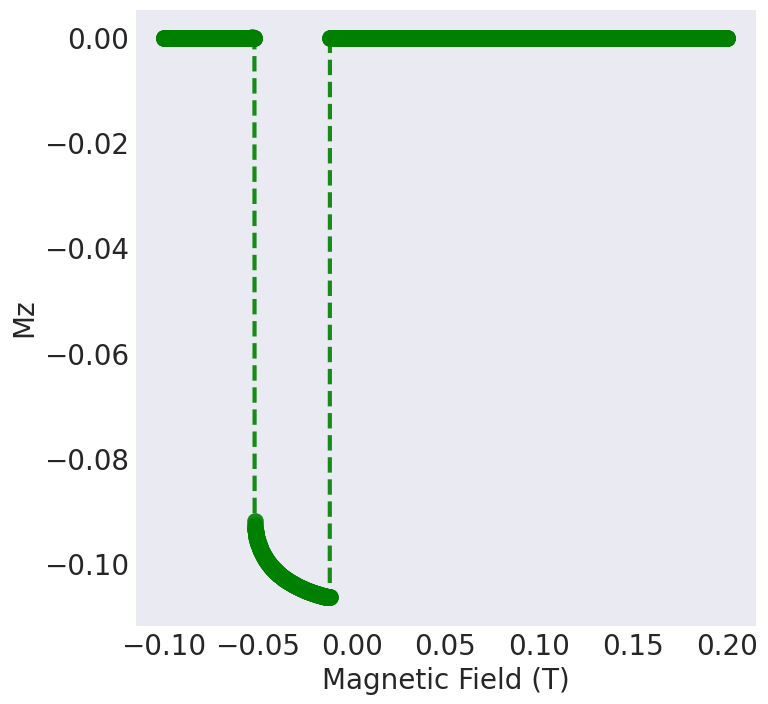

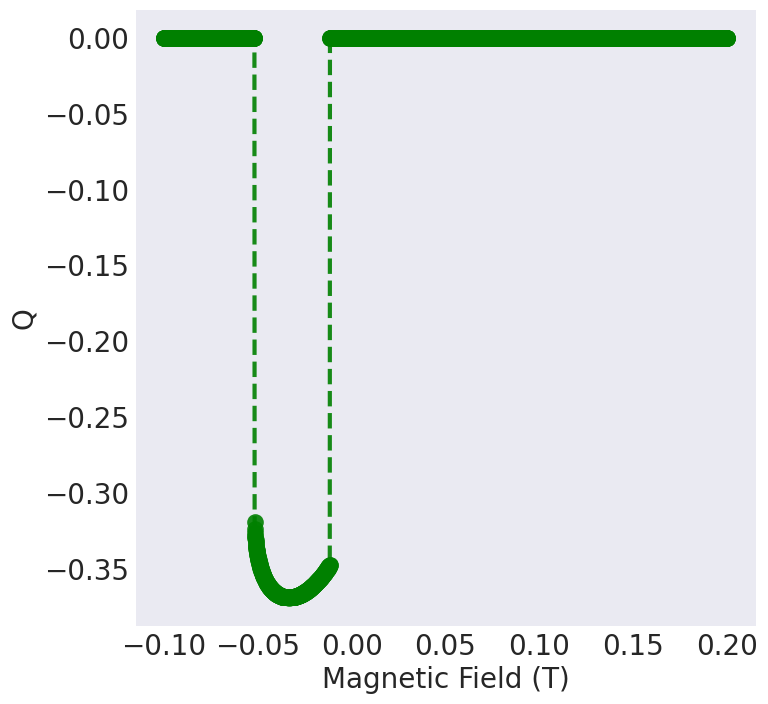

In [9]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,my, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S2, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

In [10]:
print(S)

[0.0003024853742629742, 0.00030251877312082793, 0.00030255216061202936, 0.0003025855542337959, 0.00030261895384905453, 0.00030265235981347013, 0.00030268577203129655, 0.00030271919018876465, 0.00030275261455952365, 0.000302786044839183, 0.00030281948128679006, 0.0003028529237733175, 0.0003028863729687768, 0.0003029198280899082, 0.0003029532890841206, 0.00030298675610217516, 0.0003030202296289916, 0.0003030537090357257, 0.00030308719498741175, 0.00030312068702310517, 0.0003031541847464176, 0.0003031876891501209, 0.00030322119960431295, 0.000303254716186838, 0.0003032882390822383, 0.00030332176819744815, 0.0003033553031978908, 0.00030338884425914234, 0.0003034223916833144, 0.0003034559449857784, 0.00030348950469503245, 0.00030352307071955737, 0.0003035566428288419, 0.0003035902209966276, 0.0003036238057663916, 0.0003036573962143206, 0.00030369099334607235, 0.00030372459609402045, 0.0003037582052762847, 0.0003037918209106206, 0.0003038254421789153, 0.0003038590699655429, 0.000303892704064

In [11]:
print(mz)

[0.5265319290109353, 0.5265319191694627, 0.5265319093327372, 0.5265318994940394, 0.5265318896534117, 0.5265318798107828, 0.5265318699662238, 0.5265318601196914, 0.5265318502711598, 0.5265318404207552, 0.5265318305683027, 0.526531820713989, 0.5265318108576211, 0.5265318009992866, 0.5265317911390506, 0.5265317812768314, 0.5265317714126115, 0.5265317615465077, 0.5265317516783214, 0.5265317418081807, 0.526531731936221, 0.5265317220621367, 0.5265317121861164, 0.526531702308131, 0.5265316924282099, 0.5265316825462376, 0.5265316726623581, 0.5265316627765511, 0.5265316528887187, 0.5265316429989234, 0.5265316331071602, 0.5265316232133919, 0.5265316133176556, 0.5265316034199994, 0.5265315935203124, 0.526531583618719, 0.5265315737149949, 0.5265315638094721, 0.5265315539019061, 0.5265315439922706, 0.5265315340808278, 0.5265315241673116, 0.5265315142517788, 0.5265315043343859, 0.5265314944149309, 0.526531484493457, 0.5265314745700385, 0.5265314646447157, 0.5265314547173326, 0.5265314447879176, 0.52

In [15]:
B2 = B2_array.tolist()

In [16]:
print(B2)

[0.2, 0.19990000000000002, 0.19980000000000003, 0.19970000000000004, 0.19960000000000006, 0.19950000000000007, 0.19940000000000008, 0.1993000000000001, 0.1992000000000001, 0.1991000000000001, 0.19900000000000012, 0.19890000000000013, 0.19880000000000014, 0.19870000000000015, 0.19860000000000017, 0.19850000000000018, 0.1984000000000002, 0.1983000000000002, 0.1982000000000002, 0.19810000000000022, 0.19800000000000023, 0.19790000000000024, 0.19780000000000025, 0.19770000000000026, 0.19760000000000028, 0.1975000000000003, 0.1974000000000003, 0.1973000000000003, 0.19720000000000032, 0.19710000000000033, 0.19700000000000034, 0.19690000000000035, 0.19680000000000036, 0.19670000000000037, 0.19660000000000039, 0.1965000000000004, 0.1964000000000004, 0.19630000000000042, 0.19620000000000043, 0.19610000000000044, 0.19600000000000045, 0.19590000000000046, 0.19580000000000047, 0.19570000000000048, 0.1956000000000005, 0.1955000000000005, 0.19540000000000052, 0.19530000000000053, 0.19520000000000054,

In [43]:
S[49]

0.09993098517100257